In [1]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as ticker

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

from IPython.display import HTML

def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

import datetime

# Automatic Traffic Recorders (ATR) Bikes
# Identifying Extreme Values

## Visualizing the data 

In [2]:
sql_volumes = '''
SELECT volume_15min
FROM open_data.volumes_atr_bikes
'''
volumes = pandasql.read_sql(sql_volumes, con)

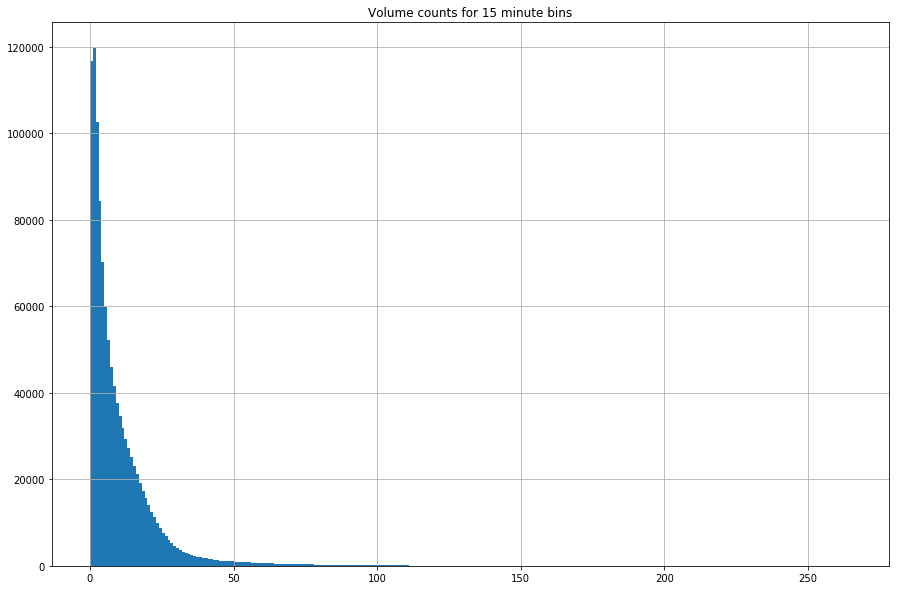

In [3]:
bin_val = np.arange(min(volumes['volume_15min']), max(volumes['volume_15min']), 1)

volumes.hist(bins=bin_val, figsize=(15,10))
plt.title('Volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)

In [4]:
max(volumes['volume_15min'])

266.0

There are 4 locations in the dataset, and each contains a large amount of data (over 15 000 records each). 

In [19]:
sql = '''
SELECT DISTINCT centreline_id, location, COUNT(*) 
FROM open_data.volumes_atr_bikes
GROUP BY centreline_id, location
'''
pandasql.read_sql(sql, con)

,centreline_id,location,count
0,1142672,Bloor and Huron,16623
1,8353520,Bloor and Markham,17017
2,8540609,BLOOR ST BIKE STN E/B W OF CASTLE FRANK CRES,565846
3,8540609,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,525774


## Removing outliers from the dataset

In [5]:
sql_volumes = '''
SELECT centreline_id, direction, location, class_type, datetime_bin, volume_15min 
FROM open_data.volumes_atr_bikes
'''

sql_locations = '''
SELECT DISTINCT ON (centreline_id, direction) centreline_id, direction
FROM open_data.volumes_atr_bikes
'''

locations = pandasql.read_sql(sql_locations, con)
volumes = pandasql.read_sql(sql_volumes, con)

In [6]:
final_df = pd.DataFrame(columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])
outliers = pd.DataFrame(columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])

for row in locations.itertuples():
    subset = volumes.loc[ (volumes['centreline_id'] == row.centreline_id) & (volumes['direction'] == row.direction) ]
    p25, p75 = np.percentile(subset['volume_15min'], 25), np.percentile(subset['volume_15min'], 75)
    iqr = p75 - p25

    # calculate outlier cut off 
    # if volume value is not between lower and upper than it will be considered an outlier
    cut_off = iqr*1.5
    lower, upper = int(p25 - cut_off), int(p75 + cut_off)
    # we cannot have a negative traffic volume
    if lower < 0: 
        lower = 0
    
    # identify outliers
    frames = [outliers, subset.loc[(subset['volume_15min'] < lower) | (subset['volume_15min'] > upper)  ]  ]
    outliers = pd.concat(frames)
    
    
    # all records that are not outliers
    frames = [final_df, subset.loc[(subset['volume_15min'] >= lower) & (subset['volume_15min'] <= upper)]  ]
    final_df = pd.concat(frames)


In [7]:
# get percentage of total records that are outliers 
(len(outliers.index) / len(volumes.index))*100 

5.456072374384586

In [8]:
# QC checks
print((len(outliers.index) + len(final_df.index)) == len(volumes.index))

True


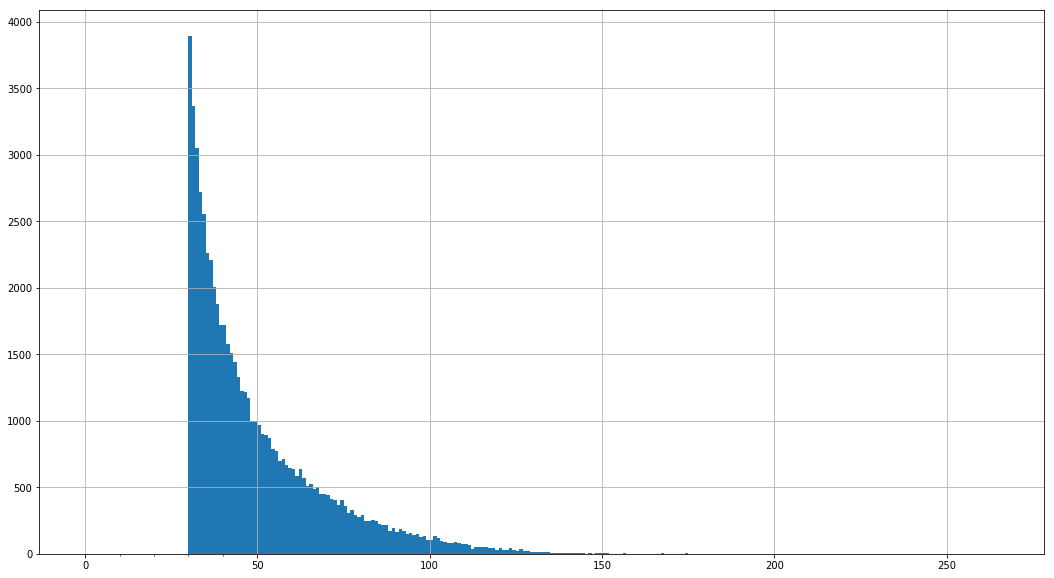

In [9]:
outliers['volume_15min'].hist(bins = np.arange(0, max(outliers['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

#ax.set_xticks(major_ticks, labels=[major_ticks])
ax.set_xticks(minor_ticks, minor=True)

In this case, the outliers are all higher values. However, these values do not seem very extreme and could potentially be attribiuted to the large variation of volumes across times of days and months. 

Investigate some of the larger outliers to see if they occur during rush hour, and see how much of the outliers in general occur during rush hour. I am checking if they occur during rush hour because there is generally higher volumes of traffic during rush hour. If most of the outliers with high volumes do not occur at rush hour, it may be evidence to prove that they are in fact extreme values (and vice versa).

In [10]:
# get all outliers that happen at rush hour with high (over 100) volumes
subset_outlier_over100 = outliers.loc[(outliers['volume_15min'] > 100) & ( (outliers['datetime_bin'].dt.hour == 9) 
                                                                          | (outliers['datetime_bin'].dt.hour == 8)
                                                                         | (outliers['datetime_bin'].dt.hour == 17)
                                                                         | (outliers['datetime_bin'].dt.hour == 16)
                                                                          | (outliers['datetime_bin'].dt.hour == 18))] 
                                    
# percent of rush hour outliers with volumes over 100 (in comparison to all outliers with values over 100)
(len(subset_outlier_over100.index) / len(outliers.loc[(outliers['volume_15min'] > 100)]))*100

93.8257993384785

In [11]:
# get all outliers that happen at rush hour
subset_outlier_over100 = outliers.loc[( (outliers['datetime_bin'].dt.hour == 9) 
                                                                          | (outliers['datetime_bin'].dt.hour == 8)
                                                                         | (outliers['datetime_bin'].dt.hour == 17)
                                                                         | (outliers['datetime_bin'].dt.hour == 16)
                                                                        | (outliers['datetime_bin'].dt.hour == 18))] 
                                    
# percent of rush hour outliers (in comparison to all outliers)
(len(subset_outlier_over100.index) / len(outliers))*100

67.07712354426256

In [12]:
# get all outliers that do not happen at rush hour with high (over 100) volumes
subset_outlier_over100 = outliers.loc[(outliers['volume_15min'] > 100) & ( (outliers['datetime_bin'].dt.hour != 9) 
                                                                          & (outliers['datetime_bin'].dt.hour != 8)
                                                                         & (outliers['datetime_bin'].dt.hour != 17)
                                                                         & (outliers['datetime_bin'].dt.hour != 16)
                                                                           & (outliers['datetime_bin'].dt.hour != 18))] 
                                    
subset_outlier_over100
#len(subset_outlier_over100.index)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min
179531,8540609,Eastbound,BLOOR ST BIKE STN E/B W OF CASTLE FRANK CRES,Cyclists,1997-11-03 06:15:00,102.0
612513,8540609,Eastbound,BLOOR ST BIKE STN E/B W OF CASTLE FRANK CRES,Cyclists,2007-10-12 13:00:00,116.0
669175,8540609,Eastbound,BLOOR ST BIKE STN E/B W OF CASTLE FRANK CRES,Cyclists,2010-06-18 15:45:00,106.0
904589,8540609,Eastbound,BLOOR ST BIKE STN E/B W OF CASTLE FRANK CRES,Cyclists,2014-04-23 12:15:00,120.0
57479,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,1995-08-16 07:30:00,126.0
108913,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,1996-07-30 05:00:00,203.0
180476,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,1997-11-08 04:15:00,116.0
180482,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,1997-11-08 05:00:00,128.0
180484,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,1997-11-08 05:15:00,110.0
380344,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,2002-09-04 07:45:00,102.0


Most of the highest values happen during rush hour, which makes their high values make sense. There are 112 cases where a volume is an outlier has a volume of over 100 but does not happen during rush hour.

### Explore modification to the IQR process
Try to modify the IQR process slightly to change the percentiles from 25 and 75 to 5 and 95 (I also tried 10 and 90, 5 and 90 but found this one to be the best). 

In [13]:
final_df = pd.DataFrame(columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])
outliers = pd.DataFrame(columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])

for row in locations.itertuples():
    subset = volumes.loc[ (volumes['centreline_id'] == row.centreline_id) & (volumes['direction'] == row.direction) ]
    p25, p75 = np.percentile(subset['volume_15min'], 5), np.percentile(subset['volume_15min'], 95)
    iqr = p75 - p25

    # calculate outlier cut off 
    # if volume value is not between lower and upper than it will be considered an outlier
    cut_off = iqr*1.5
    lower, upper = int(p25 - cut_off), int(p75 + cut_off)
    # we cannot have a negative traffic volume
    if lower < 0: 
        lower = 0
    
    # identify outliers
    frames = [outliers, subset.loc[(subset['volume_15min'] < lower) | (subset['volume_15min'] > upper)  ]  ]
    outliers = pd.concat(frames)
    
    
    # all records that are not outliers
    frames = [final_df, subset.loc[(subset['volume_15min'] >= lower) & (subset['volume_15min'] <= upper)]  ]
    final_df = pd.concat(frames)


In [14]:
# get percentage of total records that are outliers 
(len(outliers.index) / len(volumes.index))*100 

0.5221015587508665

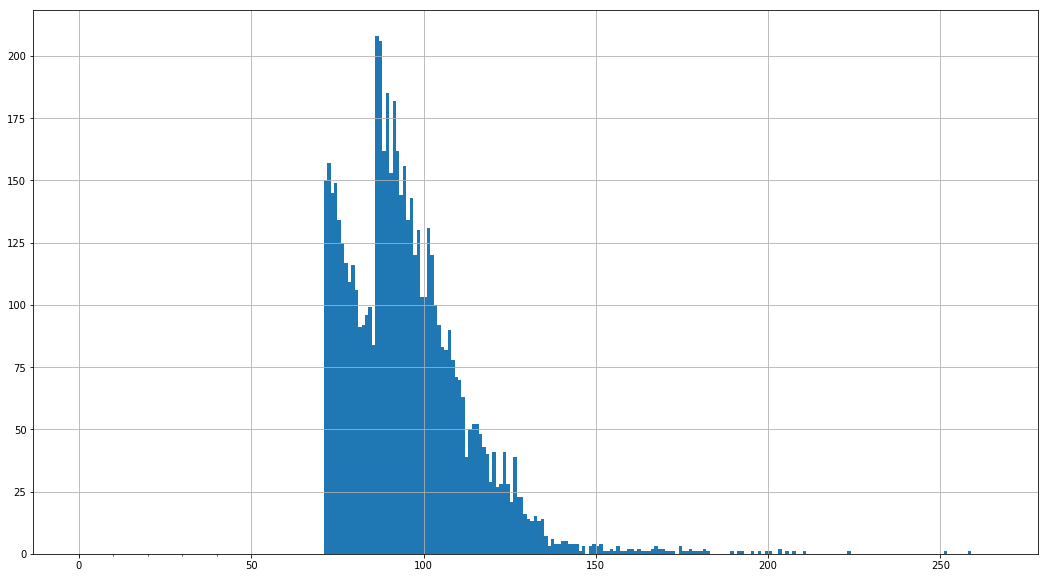

In [88]:
# plot outliers
outliers['volume_15min'].hist(bins = np.arange(0, max(outliers['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

#ax.set_xticks(major_ticks, labels=[major_ticks])
ax.set_xticks(minor_ticks, minor=True)

In [16]:
# get all outliers that happen at rush hour with high (over 100) volumes
subset_outlier_over100 = outliers.loc[(outliers['volume_15min'] > 100) & ( (outliers['datetime_bin'].dt.hour == 9) 
                                                                          | (outliers['datetime_bin'].dt.hour == 8)
                                                                         | (outliers['datetime_bin'].dt.hour == 17)
                                                                         | (outliers['datetime_bin'].dt.hour == 16)
                                                                          | (outliers['datetime_bin'].dt.hour == 18))] 
                                    
# percent of rush hour outliers with volumes over 100 (in comparison to all outliers with values over 100)
(len(subset_outlier_over100.index) / len(outliers.loc[(outliers['volume_15min'] > 100)]))*100

93.8257993384785

In [73]:
# get all outliers that happen at rush hour
subset_outlier_peak = outliers.loc[( (outliers['datetime_bin'].dt.hour == 9) 
                                                                          | (outliers['datetime_bin'].dt.hour == 8)
                                                                         | (outliers['datetime_bin'].dt.hour == 17)
                                                                         | (outliers['datetime_bin'].dt.hour == 16)
                                                                        | (outliers['datetime_bin'].dt.hour == 18))] 
                                    
# percent of rush hour outliers (in comparison to all outliers)
(len(subset_outlier_peak.index) / len(outliers))*100

93.22553191489362

In [74]:
# get all outliers that do not happen at rush hour with high (over 100) volumes
subset_outlier_over100 = outliers.loc[(outliers['volume_15min'] > 100) & ( (outliers['datetime_bin'].dt.hour != 9) 
                                                                          & (outliers['datetime_bin'].dt.hour != 8)
                                                                         & (outliers['datetime_bin'].dt.hour != 17)
                                                                         & (outliers['datetime_bin'].dt.hour != 16)
                                                                           & (outliers['datetime_bin'].dt.hour != 18))] 

# about 2% of outliers with volume over 100 do not occur at rush hour
(len(subset_outlier_over100.index) / len(outliers))*100

1.9063829787234043

A very large amount (over 90%) of the outliers in this case with the highest volumes occur during rush hour, which can explain why their volumes are so high. The majority of the outliers identified in this dataset occur during rush hour, and the highest volumes (i.e. 266) is about the same as the highest volume in the TMC bikes dataset. 

## Investigate non-rush hour outliers

Investigate the outliers that occur at non-rush hour times and perform an IQR test on these non-rush hour outliers.

Look at the overall distribution of when outliers occur and the outlier values at these hours.

In [80]:
# get all outliers that happen at rush hour
subset_outlier_not_peak = outliers.loc[( (outliers['datetime_bin'].dt.hour != 9) 
                                                                          & (outliers['datetime_bin'].dt.hour != 8)
                                                                         & (outliers['datetime_bin'].dt.hour != 17)
                                                                         & (outliers['datetime_bin'].dt.hour != 16)
                                                                        & (outliers['datetime_bin'].dt.hour != 18))] 

2 out of 3 of the locations with permanent bike ATR counters have about 16 000 - 18 000 volume bins, and the other one has over 1 000 000 (demonstrated near the beginning of this notebook). The below code demonstrates that all of the outliers are from Castle Frank and Bloor (which is the location with over 1 000 000 bins of data)

In [91]:
subset_outlier_not_peak.loc[(subset_outlier_not_peak['centreline_id'] != 8540609)]

,centreline_id,direction,location,class_type,datetime_bin,volume_15min,hour


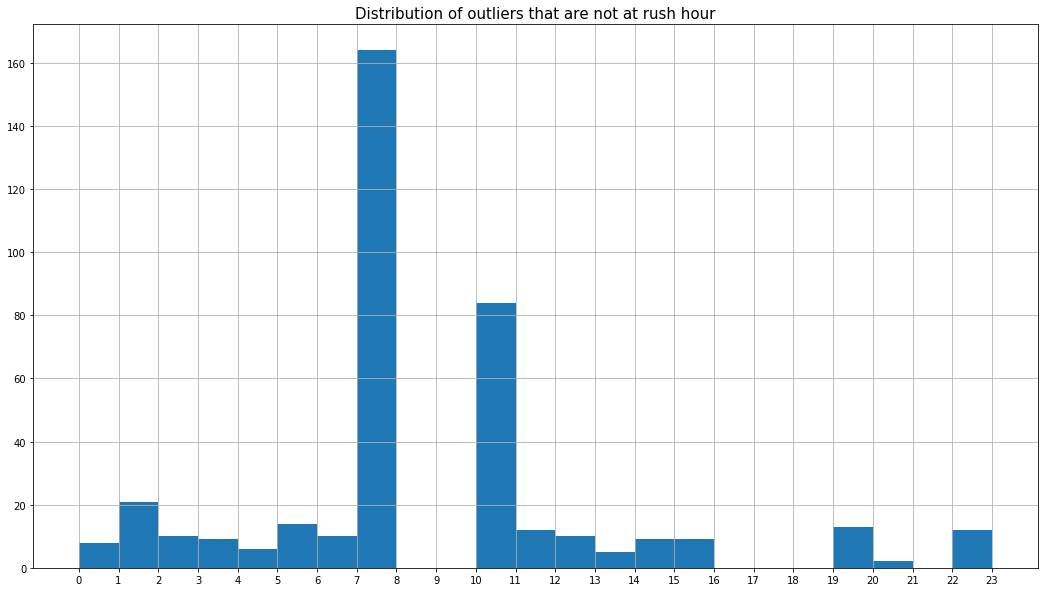

In [81]:
(subset_outlier_not_peak['datetime_bin'].dt.hour).hist(bins=np.arange(0, 24, 1), figsize = (18, 10))
plt.xticks(np.arange(0, 24, 1))
plt.title("Distribution of outliers that are not at rush hour")

Most outliers that occur outside of peak periods occur during the hours before and after the peak periods, which is expected. Look at the volume count distribution of these outliers.

In [84]:
subset_outlier_not_peak['hour'] = subset_outlier_not_peak['datetime_bin'].dt.hour

([<matplotlib.axis.XTick at 0x20df6198>,
 <a list of 24 Text xticklabel objects>)

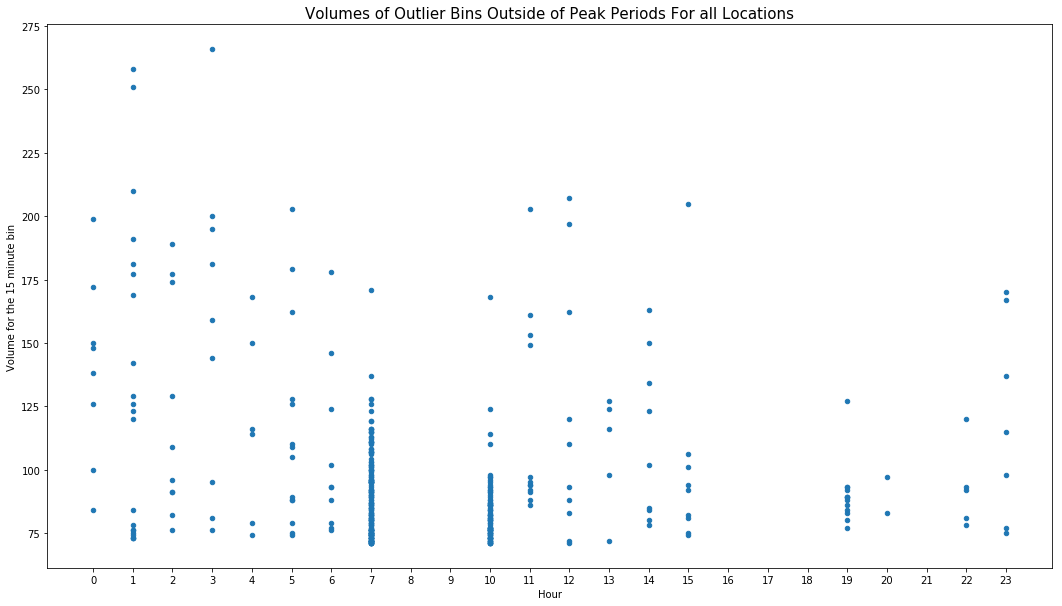

In [83]:
# look at the distribution of outlier values outside of peak periods
ax = subset_outlier_not_peak.plot.scatter('hour', 'volume_15min',  figsize = (18, 10))
ax.set_xlabel("Hour")
ax.set_ylabel("Volume for the 15 minute bin")
plt.title("Volumes of Outlier Bins Outside of Peak Periods For all Locations")
plt.xticks(np.arange(0, 24, 1))

There are some 15 minute bins with volumes that are very high (i.e. over 100) that occur during the early hours of the morning. It is unlikely that these values are correct. Take a closer look at these values. 

In [135]:
outliers_late_hours = subset_outlier_not_peak.loc[  (subset_outlier_not_peak['volume_15min'] > 100) &
                             ( 
                                 (subset_outlier_not_peak['datetime_bin'].dt.hour <= 5) |
                                 (subset_outlier_not_peak['datetime_bin'].dt.hour >= 22)
                              
                             )
                           ]
outliers_late_hours 

,centreline_id,direction,location,class_type,datetime_bin,volume_15min,hour
108913,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,1996-07-30 05:00:00,203.0,5
180476,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,1997-11-08 04:15:00,116.0,4
180482,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,1997-11-08 05:00:00,128.0,5
180484,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,1997-11-08 05:15:00,110.0,5
891266,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,2014-02-02 02:15:00,109.0,2
892730,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,2014-02-10 05:45:00,109.0,5
928608,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,2014-09-16 02:30:00,174.0,2
928610,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,2014-09-16 02:45:00,177.0,2
928612,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,2014-09-16 03:00:00,181.0,3
928614,8540609,Westbound,BLOOR ST BIKE STN W/B W OF CASTLE FRANK CRES,Cyclists,2014-09-16 03:15:00,144.0,3


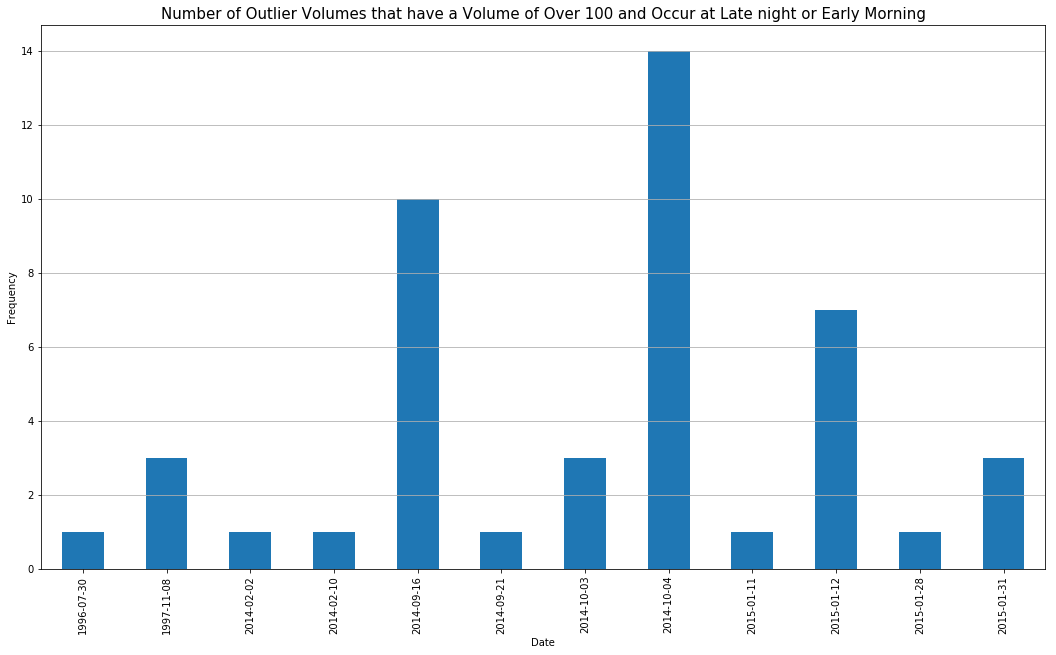

In [136]:
# look at the distributions of dates 
counts = outliers_late_hours.groupby(outliers_late_hours['datetime_bin'].dt.date).count()['centreline_id']

ax = counts.plot(kind='bar', figsize=(18, 10))
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")
ax.set_title("Number of Outlier Volumes that have a Volume of Over 100 and Occur at Late night or Early Morning")
ax.yaxis.grid()

The plot above tells us that some of the outliers that occur on the same days. As we can see from the chart above the histogram, all of the bins from October 4, 2014 and September 16, 2016 in the chart occurred throughout the early morning. All of the bins above can probably be considered to be extreme values. 

## Run IQR on one hour at the Castle Frank and Bloor Location

In order to test to see if there are any more "extreme values" at Castle Frank and Bloor, re-run the modified IQR test (using the 5th percentile and 95th percentile) on one hour of data.

In [137]:
sql_volumes = '''
SELECT centreline_id, direction, location, class_type, datetime_bin, volume_15min 
FROM open_data.volumes_atr_bikes
WHERE date_part('hr', datetime_bin) = 3
'''

sql_locations = '''
SELECT DISTINCT ON (centreline_id, direction) centreline_id, direction
FROM open_data.volumes_atr_bikes
WHERE centreline_id = 8540609
'''

locations = pandasql.read_sql(sql_locations, con)
volumes = pandasql.read_sql(sql_volumes, con)

In [140]:
final_df_3am = pd.DataFrame(columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])
outliers_3am = pd.DataFrame(columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])

for row in locations.itertuples():
    subset = volumes.loc[ (volumes['centreline_id'] == row.centreline_id) & (volumes['direction'] == row.direction) ]
    p25, p75 = np.percentile(subset['volume_15min'], 5), np.percentile(subset['volume_15min'], 95)
    iqr = p75 - p25

    # calculate outlier cut off 
    # if volume value is not between lower and upper than it will be considered an outlier
    cut_off = iqr*1.5
    lower, upper = int(p25 - cut_off), int(p75 + cut_off)
    # we cannot have a negative traffic volume
    if lower < 0: 
        lower = 0
    
    # identify outliers
    frames = [outliers_3am, subset.loc[(subset['volume_15min'] < lower) | (subset['volume_15min'] > upper)  ]  ]
    outliers_3am = pd.concat(frames)
    
    
    # all records that are not outliers
    frames = [final_df_3am, subset.loc[(subset['volume_15min'] >= lower) & (subset['volume_15min'] <= upper)]  ]
    final_df_3am = pd.concat(frames)

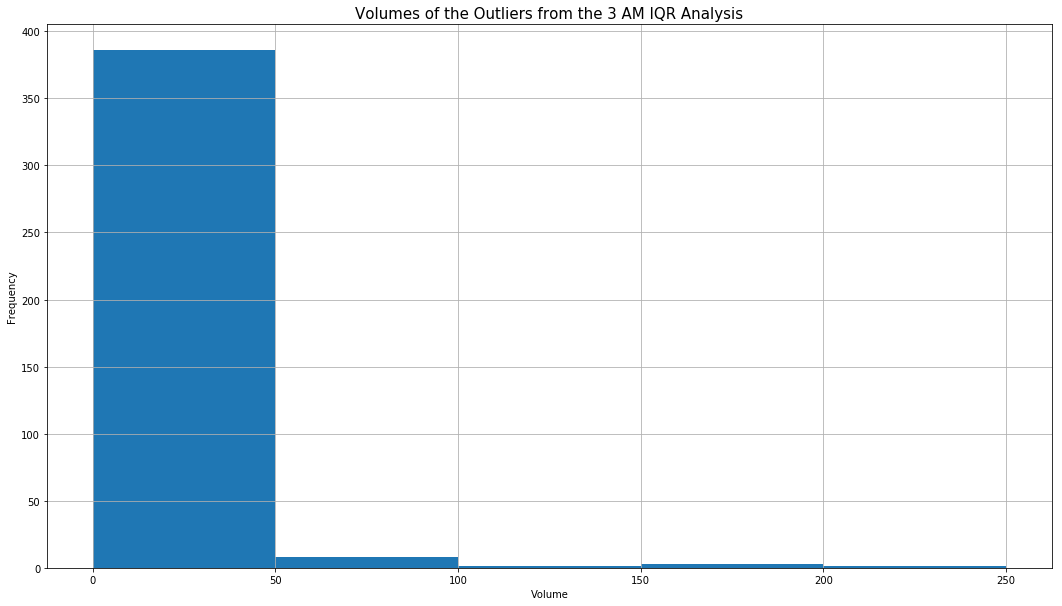

In [149]:
ax = outliers_3am['volume_15min'].hist(bins=np.arange(0, 300, 50), figsize=(18,10))
# bins of 50
ax.set_xlabel("Volume")
ax.set_ylabel("Frequency")
ax.set_title("Volumes of the Outliers from the 3 AM IQR Analysis")

The majority of the volumes that are outliers are under 50. Zoom in to see if these values are closer to 50 or 0. 

([<matplotlib.axis.XTick at 0x38bdc198>,
 <a list of 12 Text xticklabel objects>)

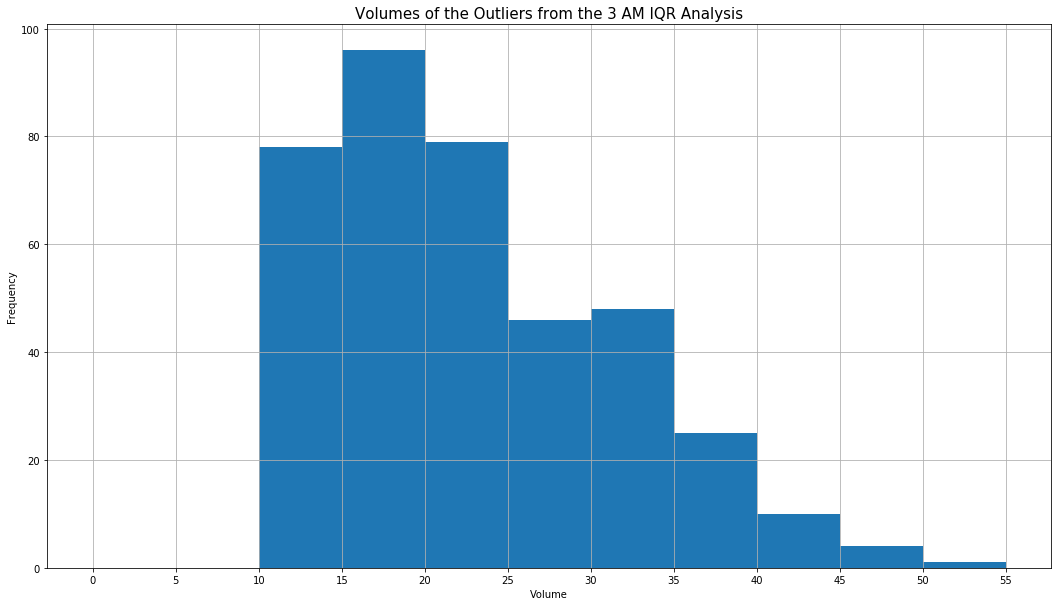

In [181]:
# zoom in to 0 to 50 
# bins of 10
ax = outliers_3am['volume_15min'].hist(bins=np.arange(0, 60, 5), figsize=(18,10))
ax.set_xlabel("Volume")
ax.set_ylabel("Frequency")
ax.set_title("Volumes of the Outliers from the 3 AM IQR Analysis")
plt.xticks(np.arange(0,60,5))

The values are mainly between 10 and 25. There are a fair amount between 25 and 40. This means that most of the outliers are not around 0 (i.e. they are not negligible). It also means that some of these volumes may not be extreme values (it is uncertain).

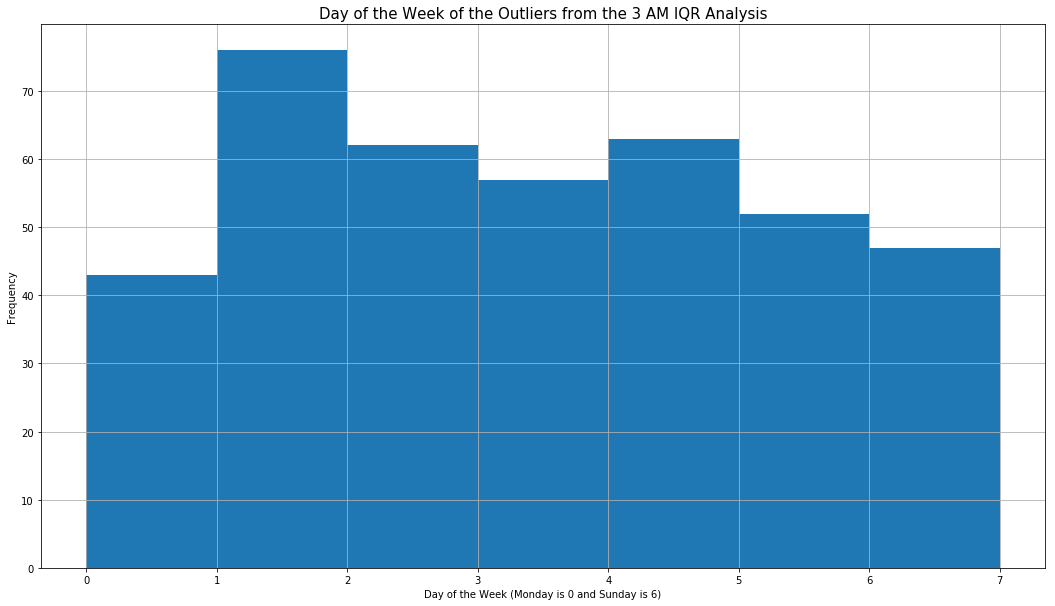

In [168]:
ax = (outliers_3am['datetime_bin'].dt.weekday).hist(bins=np.arange(0, 8, 1), figsize=(18,10))
ax.set_xlabel("Day of the Week (Monday is 0 and Sunday is 6)")
ax.set_ylabel("Frequency")
ax.set_title("Day of the Week of the Outliers from the 3 AM IQR Analysis")

# Monday is 0 and Sunday is 6

The highest number of outliers occurs on Tuesdays. I created this histogram because I thought that people going out on the weekend may have had an impact on the number of cyclists in the early hours of the morning (i.e. 3 AM). The histogram demonstrates that the day of the week does not have an impact on the number of outliers reported. 

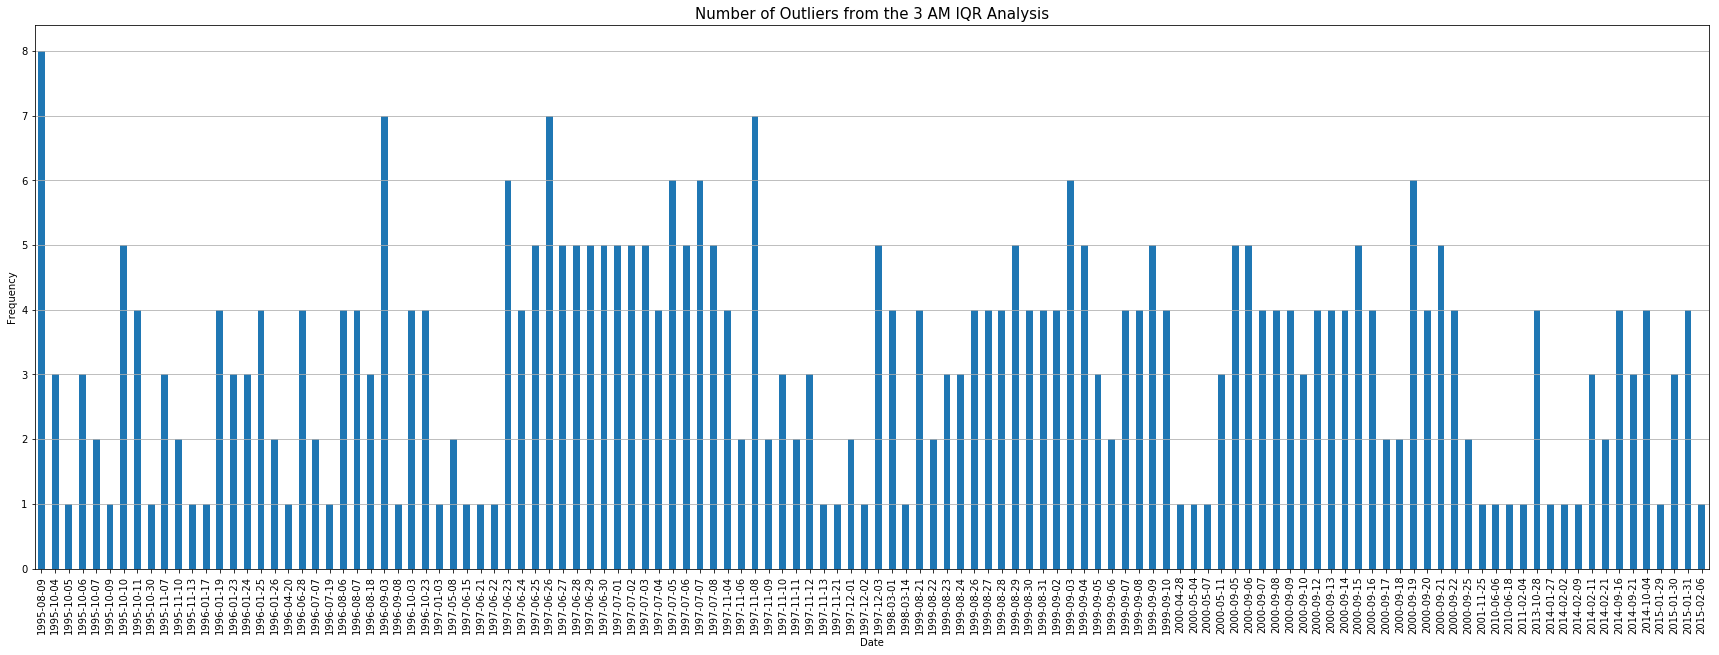

In [173]:
# look at the distributions of dates 
counts = outliers_3am.groupby(outliers_3am['datetime_bin'].dt.date).count()['centreline_id']

ax = counts.plot(kind='bar', figsize=(30, 10))
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")
ax.set_title("Number of Outliers from the 3 AM IQR Analysis")
ax.yaxis.grid()

Note that some counts are greater than 4 because the data includes both eastbound and westbound outliers. The above histogram is somewhat difficult to read, however, it shows an interesting trend. A lot of days that have bins that are in the outliers table have more than one bin that is conisdered to be an outlier. So, either there is a lot of traffic on 3 AM that day throughout the hour, or the volumes for that hour and day "extreme values", and all the volumes for that day are most likely incorrect. The latter is the most likely the answer.

In [ ]:
con.close()